In [ ]:
# upload image
# yolo to get the person
# modelm segmentation to get the parts/clothes
# search the image on the net or convert into words

In [1]:
!pip install ultralytics transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.0/899.0 kB 17.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.73k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

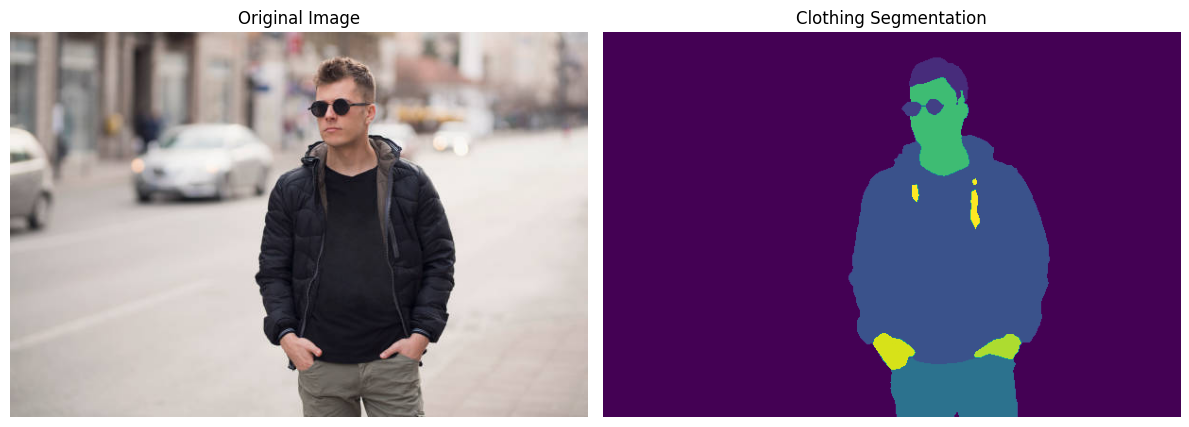

Unique classes in segmentation: [ 0  2  3  4  6 11 14 15 16]


In [5]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation

# Load the model and image processor
processor = AutoImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = SegformerForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

def predict_clothing_segmentation(image_path):
    """
    Perform semantic segmentation on a clothing image.

    Args:
        image_path (str): Path to the input image file

    Returns:
        tuple: Segmentation mask and visualization of the segmentation
    """
    # Open the image
    image = Image.open(image_path)

    # Preprocess the image
    inputs = processor(images=image, return_tensors="pt")

    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the logits (prediction scores)
    logits = outputs.logits

    # Resize the logits to the original image size
    upsampled_logits = torch.nn.functional.interpolate(
        logits,
        size=image.size[::-1],  # Reverse size for height, width
        mode="bilinear",
        align_corners=False
    )

    # Get the predicted class for each pixel
    pred_seg = upsampled_logits.argmax(dim=1)[0].numpy()

    # Visualize the segmentation
    plt.figure(figsize=(12,6))

    # Original image
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    # Segmentation mask
    plt.subplot(1,2,2)
    plt.imshow(pred_seg, cmap='viridis')
    plt.title("Clothing Segmentation")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return pred_seg

segmentation_mask = predict_clothing_segmentation('/content/model.jpg')

print("Unique classes in segmentation:", np.unique(segmentation_mask))

In [8]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation

class ClothingSegmentCropper:
    def __init__(self, model_name="mattmdjaga/segformer_b2_clothes"):
        """
        Initialize the Segformer model for clothing segmentation

        Args:
            model_name (str): Hugging Face model identifier
        """
        # Load model and processor
        self.processor = AutoImageProcessor.from_pretrained(model_name)
        self.model = SegformerForSemanticSegmentation.from_pretrained(model_name)

        # Detailed class mapping
        self.class_mapping = {
            0: "background",
            1: "hat",
            2: "hair",
            3: "glove",
            4: "sunglasses",
            5: "upper_clothes",
            6: "dress",
            7: "coat",
            8: "socks",
            9: "pants",
            10: "jumpsuits",
            11: "scarf",
            12: "skirt",
            13: "face",
            14: "left_arm",
            15: "right_arm",
            16: "left_shoe",
            17: "right_shoe"
        }

    def segment_and_crop(self, image_path, output_dir=None, min_area_ratio=0.01):
        """
        Segment and crop clothing items from an image

        Args:
            image_path (str): Path to the input image
            output_dir (str, optional): Directory to save cropped images
            min_area_ratio (float): Minimum area ratio to consider for cropping

        Returns:
            dict: Cropped clothing segments
        """
        # Open the image
        original_image = Image.open(image_path)

        # Prepare output directory
        if output_dir is None:
            output_dir = os.path.join(
                os.path.dirname(image_path),
                f"segments_{os.path.splitext(os.path.basename(image_path))[0]}"
            )
        os.makedirs(output_dir, exist_ok=True)

        # Preprocess the image
        inputs = self.processor(images=original_image, return_tensors="pt")

        # Run inference
        with torch.no_grad():
            outputs = self.model(**inputs)

        # Get the logits and upsample to original image size
        logits = outputs.logits
        upsampled_logits = torch.nn.functional.interpolate(
            logits,
            size=original_image.size[::-1],
            mode="bilinear",
            align_corners=False
        )

        # Get the predicted class for each pixel
        pred_seg = upsampled_logits.argmax(dim=1)[0].numpy()

        # Prepare to store cropped segments
        cropped_segments = {}

        # Total image area for ratio calculation
        total_area = original_image.width * original_image.height

        # Crop and save segments
        for class_id, class_name in self.class_mapping.items():
            # Skip background and less interesting classes
            if class_id in [0, 2, 13, 14, 15]:
                continue

            # Create mask for this class
            segment_mask = (pred_seg == class_id)

            # Check if segment exists
            if not segment_mask.any():
                continue

            # Find bounding box of the segment
            rows = np.any(segment_mask, axis=1)
            cols = np.any(segment_mask, axis=0)
            rmin, rmax = np.where(rows)[0][[0, -1]]
            cmin, cmax = np.where(cols)[0][[0, -1]]

            # Calculate segment area
            segment_area = (rmax - rmin) * (cmax - cmin)
            area_ratio = segment_area / total_area

            # Skip very small segments
            if area_ratio < min_area_ratio:
                continue

            # Crop the segment
            segment_img = np.array(original_image)[rmin:rmax+1, cmin:cmax+1]

            # Convert to PIL Image
            pil_segment = Image.fromarray(segment_img)

            # Save the cropped segment
            save_path = os.path.join(output_dir, f"{class_name}_segment.png")
            pil_segment.save(save_path)

            # Store in dictionary
            cropped_segments[class_name] = {
                'image': pil_segment,
                'path': save_path,
                'area_ratio': area_ratio
            }

        # Visualize segments
        self._visualize_segments(original_image, pred_seg, output_dir)

        return cropped_segments

    def _visualize_segments(self, original_image, seg_mask, output_dir):
        """
        Create a visualization of the segmentation

        Args:
            original_image (PIL.Image): Original input image
            seg_mask (numpy.ndarray): Segmentation mask
            output_dir (str): Directory to save visualization
        """
        plt.figure(figsize=(15,5))

        # Original image
        plt.subplot(1,2,1)
        plt.imshow(original_image)
        plt.title("Original Image")
        plt.axis('off')

        # Segmentation mask
        plt.subplot(1,2,2)
        plt.imshow(seg_mask, cmap='viridis')
        plt.title("Segmentation Mask")
        plt.axis('off')

        # Save visualization
        viz_path = os.path.join(output_dir, "segmentation_visualization.png")
        plt.savefig(viz_path)
        plt.close()


Detected and cropped segments:
sunglasses: Saved at /content/segments/sunglasses_segment.png (Area Ratio: 17.93%)
dress: Saved at /content/segments/dress_segment.png (Area Ratio: 6.94%)
scarf: Saved at /content/segments/scarf_segment.png (Area Ratio: 2.12%)


In [ ]:
def main():
    # Create the cropper
    cropper = ClothingSegmentCropper()

    image_path = '/content/model1.jpeg'

    # Perform segmentation and cropping
    segments = cropper.segment_and_crop(
        image_path,
        # Optional: specify custom output directory
        output_dir='/content/segments',
        # Minimum segment size (as ratio of total image)
        min_area_ratio=0.005  # 5% of image area
    )

    # Print out detected segments
    print("Detected and cropped segments:")
    for name, segment in segments.items():
        print(f"{name}: Saved at {segment['path']} (Area Ratio: {segment['area_ratio']:.2%})")

if __name__ == "__main__":
    main()